# <center> <font style="font-family: 'Times New Roman';font-size:35px"> Sentiment Analysis using US Airline Tweets </font> </center>

In [73]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import  MultinomialNB
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [74]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [77]:
# Reading the dataframe
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [78]:
df.shape

(14640, 15)

# <font style="font-family: 'Times New Roman';font-size:35px"> Exploratory data analysis </font>

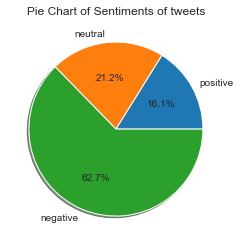

In [79]:
# Pie chart for airline sentiments
data = df.groupby('airline_sentiment').agg('count')
plt.pie(data.tweet_id.sort_values(), labels = data.tweet_id.sort_values().index,autopct = '%1.1f%%', shadow = True)
plt.title("Pie Chart of Sentiments of tweets")
plt.show()

### Observations:

### 1.There are more negative sentiments than positve and neutral combined.

### 2.There are more neutral sentiments than positive sentiments.

### 3.It might be because people feel the need to express themselves more when they have a bad experience than a good experience.

Text(0.5, 1.0, 'Number of tweets for every Airline')

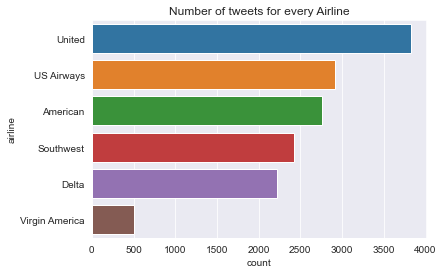

In [80]:
# Bar chart of the number of tweets for every airline
sns.countplot(data=df,y=df['airline'],order = df['airline'].value_counts().index).set_title('Number of tweets for every Airline')

### Observations:

### 1.United Airline has maximum number of tweets.

### 2.Virgin America Airline has minimum number of tweets.

Text(0.5, 1.0, 'Number of tweets for every Airline with sentiment distribution')

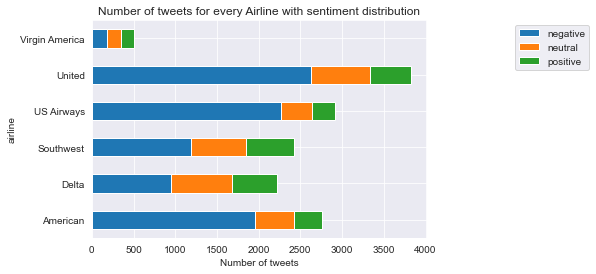

In [81]:
# Stacked bar chart of number of tweets for every Airline with sentiment distribution
types = df.groupby("airline")['airline_sentiment'].value_counts(normalize=False).sort_index()
types.unstack().plot(kind='barh', stacked='True')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.xlabel("Number of tweets")
plt.title("Number of tweets for every Airline with sentiment distribution")

### Observations:

### 1.United Airways, US Airways and American Airways has more number of negative tweets than neutral and positive combined.

### 2.Virgin America Airline has almost similar number of negative, neutral and positive tweets.

In [82]:
# Setting the negative sentiments to 0, neutral to 1 and positive to 2
def partition(x):
    if x =='negative':
        return 0
    elif x =='neutral':
        return 1
    elif x =='positive':
        return 2
actualSentiment = df['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
df['Sentiment'] = positiveNegative
df['Sentiment'].value_counts() 

0    9178
1    3099
2    2363
Name: Sentiment, dtype: int64

In [83]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,Sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


# <font style="font-family: 'Times New Roman';font-size:35px"> Data cleaning/Tweets preprocessing </font>

In [84]:
# tweets consists of every tweet as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['text']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [85]:
# stops includes both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)

In [86]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [87]:
# To get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops:
            tokens = nltk.word_tokenize(word)
            pos=pos_tag(tokens)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
docs=[ clean(doc) for doc in docs]      

In [88]:
# Let's look at how our texts look after cleaning
docs[:5]

[b'virginamerica dhepburn say',
 b"virginamerica plus 've add commercial experience ... tacky",
 b"virginamerica n't today ... must mean need take another trip",
 b"virginamerica 's really aggressive blast obnoxious `` entertainment '' guest face amp little recourse",
 b"virginamerica 's really big bad thing"]

# <font style="font-family: 'Times New Roman';font-size:35px"> Splitting the data into train and test sets </font>

In [89]:
# Taking the clean text as independent varaible and the predicted sentiments as the dependent variable 
X = np.array(docs)
Y = np.array(df['Sentiment'])
# splitting into train-test-validation set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.2, random_state=0)

In [90]:
# Looking at the shapes of each of the training, test and validation sets 
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (9808,) (9808,)
X_test, Y_test (4832,) (4832,)
X_tr, Y_tr (7846,) (7846,)
X_cv, Y_cv (1962,) (1962,)


# <font style="font-family: 'Times New Roman';font-size:35px"> Defining functions to evaluate the models </font>

In [91]:
def mulnb(X_train,X_cv,Y_train,Y_cv):
    best_alpha=0
    max_roc_auc=-1
    # Appending auc scores of cross validation and training set in the below arrays respectively
    pred_cv = []
    pred_train = []
    alpha=[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005] 
    for i in alpha[-10:]:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train)
        probs = mulbnb.predict_proba(X_cv)
        prob = mulbnb.predict_proba(X_train)
        weighted_roc_auc_ovo_cv = roc_auc_score(Y_cv,probs, multi_class="ovr",
                                     average="weighted")
        weighted_roc_auc_ovo_train = roc_auc_score(Y_train,prob, multi_class="ovr",
                                     average="weighted")
        print(i," ------> ",weighted_roc_auc_ovo_cv)
        pred_cv.append(weighted_roc_auc_ovo_cv)
        pred_train.append(weighted_roc_auc_ovo_train)
        if(max_roc_auc<weighted_roc_auc_ovo_cv):
            max_roc_auc=weighted_roc_auc_ovo_cv
            best_alpha=i
    print(f"\n Best alpha Value is {best_alpha} with highest roc_auc Score {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()

In [92]:
#The below two lists are created to store auc and f1 scores respectively for both the vectorizations we are going to use 
AUC,F1=[],[]
def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    bnb = MultinomialNB(optimal_alpha,fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    probs = bnb.predict_proba(X_test) 
    print("AUC Score",roc_auc_score(Y_test,probs, multi_class="ovr",
                                     average="weighted"))
    AUC.append(round(roc_auc_score(Y_test,probs, multi_class="ovr",
                                     average="weighted"),2))
    prediction=bnb.predict(X_test)
    cm=confusion_matrix(Y_test,prediction)
    cm1 = pd.DataFrame(cm , index = ['positive','neutral','negative'] , columns = ['positive','neutral','negative'])
    plt.figure(figsize = (10,10))
    ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    ax.set(xlabel="Actual Sentiment", ylabel = "Predicted Sentiment")
    # Printing f1 score and hamming loss
    print("f1 score for data :",metrics.f1_score(Y_test, prediction, average='weighted'))
    F1.append(round(metrics.f1_score(Y_test, prediction, average='micro'),2))
    print("Hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

# <font style="font-family: 'Times New Roman';font-size:35px"> Bag Of Words Vectorization </font>

In [93]:
# Bag Of Words Vectorization with unigrams and bigrams
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
bow= count_vect.fit(X_tr)
bow_train = bow.transform(X_tr)
sum_words = bow_train.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in bow.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Top 20 words with their frequencies in training set are",words_freq[:20])
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

Top 20 words with their frequencies in training set are [('flight', 2410), ('united', 2272), ('usairways', 1611), ('americanair', 1599), ('southwestair', 1293), ('jetblue', 1254), ('get', 1089), ('co', 654), ('http', 652), ('http co', 652), ('hour', 632), ('thanks', 601), ('cancelled', 587), ('service', 555), ('help', 532), ('time', 523), ('customer', 512), ('call', 413), ('bag', 409), ('plane', 390)]
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (7846, 61280)
CV Data Size:  (1962, 61280)
Test Data Size:  (4832, 61280)


In [94]:
# Normalizing bow data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (7846, 61280)
CV Data Size:  (1962, 61280)
Test Data Size:  (4832, 61280)


100  ------>  0.7748615206430086
50  ------>  0.7976391556254141
10  ------>  0.8382559091101943
5  ------>  0.8510010520891678
1  ------>  0.8764000756442906
0.5  ------>  0.8856632899233131
0.1  ------>  0.8964438953236621
0.05  ------>  0.8951390726101858
0.01  ------>  0.8874348809569604
0.005  ------>  0.883453641829448

 Best alpha Value is 0.1 with highest roc_auc Score 0.8964438953236621


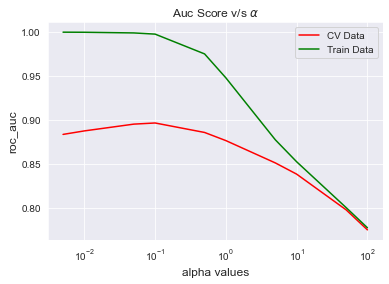

In [95]:
# Finding optimal value of alpha for count vectorization
mulnb1(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score 0.8831161617489123
f1 score for data : 0.6949449713054892
hamming loss for data: 0.26138245033112584
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.73      0.99      0.84      3049
           1       0.73      0.27      0.39      1011
           2       0.86      0.38      0.53       772

    accuracy                           0.74      4832
   macro avg       0.77      0.54      0.59      4832
weighted avg       0.75      0.74      0.69      4832



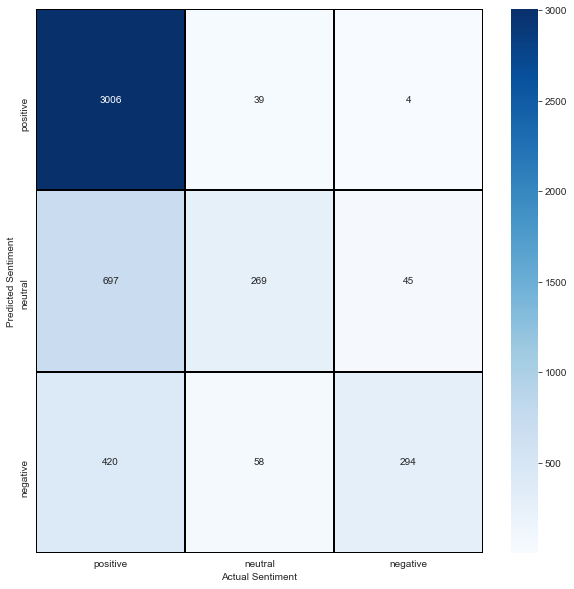

In [96]:
# optimal_alpha=0.05
testing1(bow_train,Y_tr,bow_test,Y_test,optimal_alpha=0.1)

# <font style="font-family: 'Times New Roman';font-size:35px"> TF-IDF Vectorization </font>

In [97]:
# TF-IDF Vectorization with unigrams and bigrams
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10000:10010])                                                              
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

some sample features(unique words in the corpus) ['brisk', 'brisk boston', 'british_airways', 'british_airways try', 'british_airways week', 'brittany', 'brittany love', 'brizzyberg27', 'brizzyberg27 miss', 'bro']
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (7846, 61280)
CV Data Size:  (1962, 61280)
Test Data Size:  (4832, 61280)


In [98]:
# Normalizing data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (7846, 61280)
CV Data Size:  (1962, 61280)
Test Data Size:  (4832, 61280)


100  ------>  0.8214211491385803
50  ------>  0.8294651576463294
10  ------>  0.8513544938057892
5  ------>  0.8611213622497774
1  ------>  0.8821028649167114
0.5  ------>  0.8886558311269014
0.1  ------>  0.8910434959669913
0.05  ------>  0.886872489083515
0.01  ------>  0.8754568415719151
0.005  ------>  0.8708224657619723

 Best alpha Value is 0.1 with highest roc_auc Score 0.8910434959669913


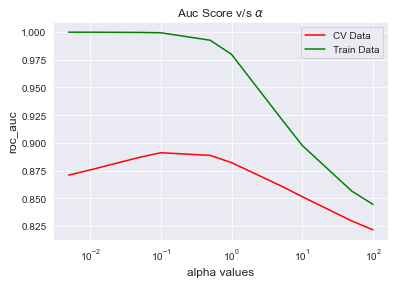

In [99]:
# Finding optimal_alpha for tfidf vectorization
mulnb(tfidf_train,tfidf_cv,Y_tr,Y_cv)

AUC Score 0.8764441611592055
f1 score for data : 0.7056425884126497
Hamming loss for data: 0.2574503311258278
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84      3049
           1       0.70      0.29      0.41      1011
           2       0.82      0.42      0.56       772

    accuracy                           0.74      4832
   macro avg       0.75      0.56      0.60      4832
weighted avg       0.74      0.74      0.71      4832



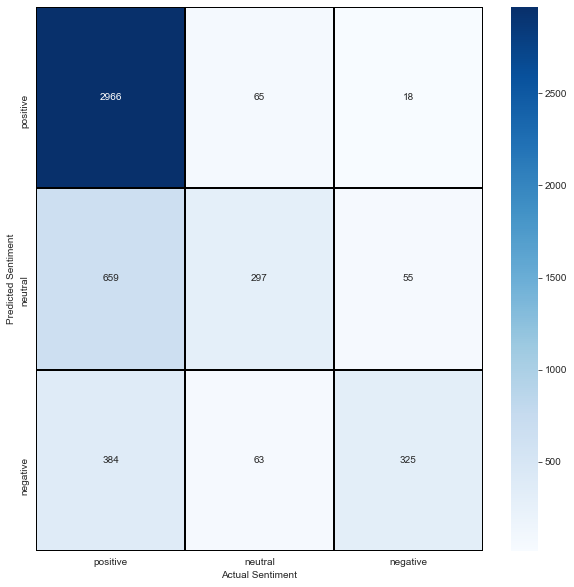

In [100]:
# Using optimal alpha=0.1 for testing
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_alpha=0.1)

In [101]:
# Displaying how the Multinomial Naive Bayes performed for both BOW and TF-IDF Vectorization
from IPython.display import display
# Intialising data of lists
data = {'Category':['BOW Vectorization','TF-IDF Vectorization'],
        'AUC Score':AUC,
        'F1-Score':F1}
df1 = pd.DataFrame(data)
 
# Printing the output.
display(df1)      

,Category,AUC Score,F1-Score
0,BOW Vectorization,0.88,0.74
1,TF-IDF Vectorization,0.88,0.74


# <font style="font-family: 'Times New Roman';font-size:35px"> Testing the model </font>

In [102]:
df=pd.read_csv('Tweets.csv')
# Setting the negative sentiments to 0, neutral to 1 and positive to 2 
def partition(x):
    if x =='negative':
        return 0
    elif x =='neutral':
        return 1
    elif x =='positive':
        return 2
actualSentiment = df['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
df['Sentiment'] = positiveNegative
df['Sentiment'].value_counts() 

0    9178
1    3099
2    2363
Name: Sentiment, dtype: int64

In [103]:
bnb=MultinomialNB()
X = tf_idf_vect.transform(df['text'])
y = df['Sentiment']
# Splitting into train-test set
from imblearn.combine import SMOTETomek
smtom = SMOTETomek(random_state=100)
X_smtom,y_smtom = smtom.fit_resample(X,y)
X_train, X_test, Y_train, Y_test = train_test_split(X_smtom, y_smtom, test_size=.2, random_state=0)
bnb.fit(X_train,Y_train)

MultinomialNB()

In [104]:
sample_text = ('The flight journey was great.Everything was good about it.')
k=tf_idf_vect.transform([sample_text])
result = bnb.predict(k)
if result[0] == 0:
    print("Negative")
elif result[0] == 1:
    print("Neutral")
else:
    print("Positive")

Positive


In [105]:
sample_text = ('The flight was pathetic and terrible.')
k=tf_idf_vect.transform([sample_text])
result = bnb.predict(k)
if result[0] == 0:
    print("Negative")
elif result[0] == 1:
    print("Neutral")
else:
    print("Positive")

Negative


In [106]:
sample_text = ('The flight was okay.')
k=tf_idf_vect.transform([sample_text])
result = bnb.predict(k)
if result[0] == 0:
    print("Negative")
elif result[0] == 1:
    print("Neutral")
else:
    print("Positive")

Neutral


In [107]:
# Saving the tfidf model for further deployment
import pickle
with open('transform.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(tf_idf_vect, file)

In [108]:
# Saving the multinomial naive bayes model for further deployment
with open('tsa.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(bnb, file)